# Clustering Wave File

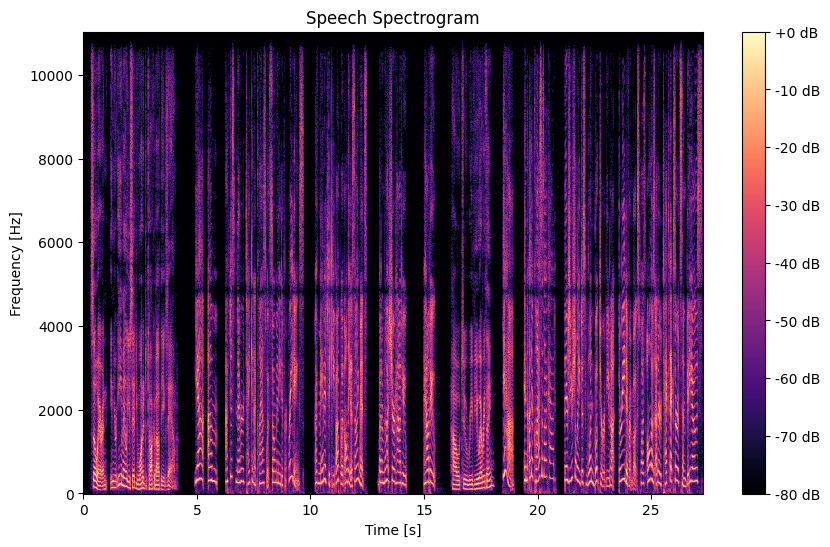

In [6]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Load audiofile
y, sr = librosa.load("data/benchmark/wav/test.wav")
seconds = len(y)/22050

# Short-Time Fourier Transform (STFT)
S = librosa.stft(y)
seconds = len(y)/22050
# Convert amplitudes in decibel
S_dB = librosa.amplitude_to_db(np.abs(S), ref=np.max)

# Plotting
plt.figure(figsize=(10, 6))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Speech Spectrogram')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.show()

# Failed: Clustering Based on Engineered Features

/home/jakob/neuefische/ds-capstone-speakequal/.venv/lib/python3.11/site-packages/librosa/feature/spectral.py:520: ComplexWarning: Casting complex values to real discards the imaginary part
  valley[..., k, :] = np.mean(sortedr[..., :idx, :], axis=-2)
/home/jakob/neuefische/ds-capstone-speakequal/.venv/lib/python3.11/site-packages/librosa/feature/spectral.py:521: ComplexWarning: Casting complex values to real discards the imaginary part
  peak[..., k, :] = np.mean(sortedr[..., -idx:, :], axis=-2)


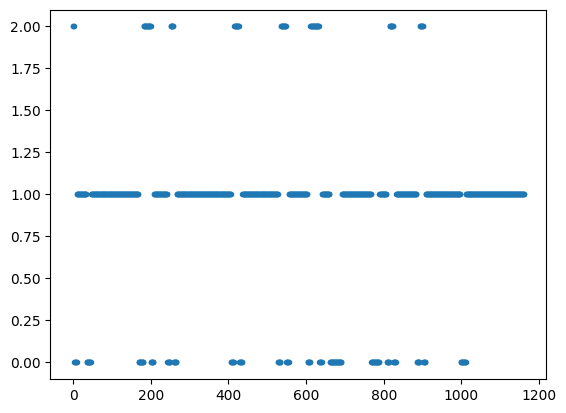

In [48]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.cluster import AgglomerativeClustering, KMeans, MiniBatchKMeans, Birch, DBSCAN


# Load the audio file
y, sr = librosa.load("data/benchmark/wav/test.wav")

# Calculate the Short-Time Fourier Transform (STFT)
D = librosa.stft(y)

# Convert the spectrogram to the Mel scale
S = librosa.feature.melspectrogram(S=D, sr=sr)

# Extract Spectral Features
spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
spectral_contrast = librosa.feature.spectral_contrast(S=D, sr=sr)
spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)
mfccs = librosa.feature.mfcc(S=librosa.power_to_db(np.abs(S)), sr=sr, n_mfcc=20)

# Transpose features so that each row corresponds to a time frame
spectral_centroid = spectral_centroid.T
spectral_bandwidth = spectral_bandwidth.T
spectral_contrast = spectral_contrast.T
spectral_rolloff = spectral_rolloff.T
zero_crossing_rate = zero_crossing_rate.T
mfccs = mfccs.T

# Create a DataFrame with all the features
# We will use `pd.concat` to combine the features along the second axis (columns)
df = pd.concat([
    pd.DataFrame(spectral_centroid, columns=['spectral_centroid']),
    pd.DataFrame(spectral_bandwidth, columns=['spectral_bandwidth']),
    pd.DataFrame(spectral_contrast, columns=[f'spectral_contrast_{i}' for i in range(spectral_contrast.shape[1])]),
    pd.DataFrame(spectral_rolloff, columns=['spectral_rolloff']),
    pd.DataFrame(zero_crossing_rate, columns=['zero_crossing_rate']),
    pd.DataFrame(mfccs, columns=[f'mfcc_{i+1}' for i in range(mfccs.shape[1])])
], axis=1)

# Display the DataFrame
#display(df)

df = pd.DataFrame(mfccs)
df_new = df.rolling(window=15).mean()

df_new.dropna(inplace=True)

# Clustering
clustering = AgglomerativeClustering(n_clusters=3).fit_predict(df_new)

# Plotting the results
plt.plot(clustering,".")


# Trying Out X-Vectors

/home/jakob/neuefische/ds-capstone-speakequal/.venv/lib/python3.11/site-packages/speechbrain/utils/checkpoints.py:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.lo

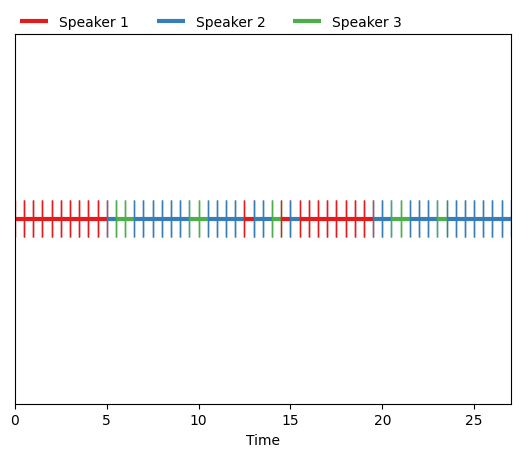

In [42]:
import torch
import torchaudio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from speechbrain.inference import SpeakerRecognition
from sklearn.cluster import AgglomerativeClustering, KMeans, MiniBatchKMeans, Birch, DBSCAN, SpectralCoclustering
from pyannote.core import Segment, Annotation, notebook
from pyannote.metrics.diarization import DiarizationErrorRate


# Load pre-trained x-vector model
xvector_model = SpeakerRecognition.from_hparams(
    source="speechbrain/spkrec-xvect-voxceleb",
    savedir="pretrained_models/spkrec-xvect-voxceleb"
)

# Load audio file (fs is sampling rate)
signal, fs = torchaudio.load("data/benchmark/wav/test.wav")

# Ensure the audio is mono and 16kHz
if signal.shape[0] > 1:
    signal = torch.mean(signal, dim=0, keepdim=True)

if fs != 16000:
    signal = torchaudio.transforms.Resample(fs, 16000)(signal)

# Define segment length and step
segment_length = .5  # adjust to preference
step = .5  # adjust to preference
segment_length_samples = int(segment_length * 16000)
step_samples = int(step * 16000)

# Extract x-vectors for each segment
xvectors = []
segments = []
for start in range(0, signal.shape[1] - segment_length_samples, step_samples):
    segment = signal[:, start:start + segment_length_samples]
    xvector = xvector_model.encode_batch(segment)
    xvectors.append(xvector.squeeze().detach().numpy())
    segments.append(Segment(start / 16000, (start + segment_length_samples) / 16000))

xvectors = np.array(xvectors)

# Perform agglomerative clustering
num_speakers = 3  # Change this number based on expected number of speakers
labels = AgglomerativeClustering(n_clusters=num_speakers).fit_predict(xvectors)
#labels = DBSCAN(eps=.19, min_samples=10, metric="cosine", n_jobs=-1).fit_predict(xvectors)

# Create a pyannote annotation for visualization and output
annotation = Annotation()
for i, label in enumerate(labels):
    annotation[segments[i]] = f"Speaker {label + 1}"

# Display the diarization result
notebook.plot_annotation(annotation, time=True, legend=True)

# #Convert to Pandas DataFrame for easier handling
# df = pd.DataFrame({
#     "start": [segment.start for segment in segments],
#     "end": [segment.end for segment in segments],
#     "speaker": [f"Speaker {label + 1}" for label in labels]
# })


In [15]:

ref_annotation = Annotation()
benchmark = pd.read_csv("data/example3.csv", header=None)
for index, row in benchmark.iterrows():
    ref_annotation[Segment(row[0], row[1])] = row[2]
with open('data/example3_manual_annotations.rttm', 'w') as file:
    ref_annotation.write_rttm(file)


# Instantiate diarization
err = DiarizationErrorRate()
err.compute_components(ref_annotation,annotation)


ValueError: Space-separated RTTM file format does not allow labels containing spaces (got: " "Speaker 0"").

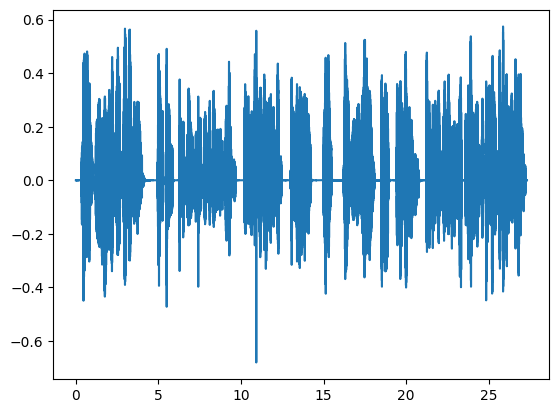

In [1]:
import librosa
import matplotlib.pyplot as plt
import numpy as np

# Load audiofile (sr is sample rate)
y, sr = librosa.load("data/test.wav")
x_axis = np.array(range(len(y)))/sr

# Short-Time Fourier Transform (STFT)
S = librosa.stft(y)

# Convert amplitudes in decibel
S_dB = librosa.amplitude_to_db(np.abs(S), ref=np.max)

# Plotting
plt.plot(x_axis,y)